# Add environmental data
This notebook is the code to add environmental data to the output of pypam
For more information about this process please contact clea.parcerisas@vliz.be or check the documentation of both packages
https://lifewatch-pypam.readthedocs.io/en/latest/
https://github.com/lifewatch/bpnsdata

In [2]:
import pathlib
import os

import geopandas
import pandas as pd
import xarray
from tqdm import tqdm

import bpnsdata

import erddapy
print(erddapy.__version__)

C:\Users\cleap\Envs\wadden_soundscape\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


2.0.2


In [3]:
raw_data_path = pathlib.Path('./data/raw_data')
processed_data_path = pathlib.Path('./data/processed')
metadata_path = raw_data_path.joinpath('data_summary_mda.csv')
metadata = pd.read_csv(metadata_path, index_col=False)

if not processed_data_path.exists():
    os.mkdir(processed_data_path)

env_vars = [
		"shipping",
		"time",
		"bathymetry"
    ]


# Change this to the columns you add in the csv!
# YOU NEED TO KEEP deployment_name
env_vars_from_csv = ['sediment_type', 'other_var', 'new_var', 'deployment_name']

In [4]:
metadata

,deployment_name,campaign,instrument_name,instrument_sensitivity,instrument_amp,instrument_Vpp,deployment_path,timezone,include_dirs,calibration,latitude,longitude,end_to_end_calibration,sediment_type,other_var,new_var
0,NLOyster1,1,SoundTrap,0,-170,2,0_NLOyster1.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,1,a
1,NLOyster2,1,SoundTrap,0,-170,2,1_NLOyster2.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,1,a
2,NLSand1,2,SoundTrap,0,-170,2,2_NLSand1.nc,UTC,0,-1,53.06843,5.20231,NaN,sand,2,a
3,NLSand2,2,SoundTrap,0,-160,2,3_NLSand2.nc,UTC,0,-1,53.06843,5.20231,NaN,sand,2,a


In [8]:
# Define the seadatamanager
manager = bpnsdata.SeaDataManager(env_vars)
id_name = 'id'
datetime_name = 'datetime'
for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    deployment_path = raw_data_path.joinpath('deployments/deployments', row['deployment_path'])
    env_path = processed_data_path.joinpath(row['deployment_path'].replace('.nc', '_env.nc'))
    print(env_path)

    # Read the dataset
    ds_deployment = xarray.open_dataset(deployment_path, engine='netcdf4')
    # Get the time information from the dataset to get a pandas df
    datetime_index = ds_deployment[datetime_name].to_index()
    df = pd.DataFrame({"datetime": datetime_index.values, 'id': ds_deployment[id_name]})
    df = df.drop_duplicates("datetime")
    print(metadata.iloc[i]['deployment_name'], len(datetime_index), len(df))
    df.datetime = df.datetime.dt.tz_localize('UTC')

    df['latitude'] = row['latitude']
    df['longitude'] = row['longitude']

    # Generate the location information
    geodf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(x=df['longitude'], y=df['latitude']), crs='EPSG:4326')
    geodf_env = manager(geodf, datetime_column='datetime')

    for env_var in env_vars_from_csv:
        geodf_env[env_var] = row[env_var]

    # Remove the UTC (xarray does not support it?)
    geodf_env.datetime = geodf_env.datetime.dt.tz_localize(None)
    lat = geodf_env['geometry'].y
    lon = geodf_env['geometry'].x
    df_env = geodf_env.drop(columns=['geometry', 'id'])
    env_ds = df_env.to_xarray()
    env_ds = env_ds.assign_coords(coords={'lat': lat, 'lon': lon, id_name : ('datetime', df.id.values)})
    env_ds = env_ds.swap_dims({'datetime': id_name})

    # Clean the previous if not all computed
    if len(env_ds[id_name]) != len(ds_deployment[id_name]):
        env_ds = env_ds.reindex_like(ds_deployment)
    new_ds = ds_deployment.merge(env_ds, compat="override")
    new_ds['season'] = new_ds[datetime_name].dt.isocalendar().week

    encoding = {'file_path': {'dtype': 'unicode'},
                'start_sample': {'dtype': int, '_FillValue': -1},
                'end_sample': {'dtype': int, '_FillValue': -1},
                'datetime': {'dtype': float, '_FillValue': -1},
                'deployment_name': {'dtype': str,}}
    new_ds.to_netcdf(env_path,  encoding=encoding)
    print(ds_deployment)
    ds_deployment.close()

  0%|          | 0/4 [00:00<?, ?it/s]

data\processed\0_NLOyster1_env.nc
NLOyster1 237 237


 25%|██▌       | 1/4 [00:04<00:14,  4.83s/it]

<xarray.Dataset>
Dimensions:                 (id: 237, frequency: 31, band: 1)
Coordinates: (12/13)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 231 232 233 234 235 236
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-29T22:00:09 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    hydrophone_Vpp          (id) int32 ...
    _start_frame            (id) int32 ...
  * frequency               (frequency) float64 9.843 12.4 ... 8e+03 1.008e+04
  * band                    (band) int32 0
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
Data variables:
    oct3                    (id, frequency) float64 ...
    rms                     (id, band) float64 ...
    sel                     (id, band) float64 ...
    aci                     (id, band) float64 ...
data\

 50%|█████     | 2/4 [00:09<00:09,  4.77s/it]

<xarray.Dataset>
Dimensions:                 (id: 235, frequency: 31, band: 1)
Coordinates: (12/13)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 229 230 231 232 233 234
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-30T17:10:08 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    hydrophone_Vpp          (id) int32 ...
    _start_frame            (id) int32 ...
  * frequency               (frequency) float64 9.843 12.4 ... 8e+03 1.008e+04
  * band                    (band) int32 0
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
Data variables:
    oct3                    (id, frequency) float64 ...
    rms                     (id, band) float64 ...
    sel                     (id, band) float64 ...
    aci                     (id, band) float64 ...
data\

 75%|███████▌  | 3/4 [00:14<00:04,  4.75s/it]

<xarray.Dataset>
Dimensions:                 (id: 235, frequency: 31, band: 1)
Coordinates: (12/13)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 229 230 231 232 233 234
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-29T21:30:10 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    hydrophone_Vpp          (id) int32 ...
    _start_frame            (id) int32 ...
  * frequency               (frequency) float64 9.843 12.4 ... 8e+03 1.008e+04
  * band                    (band) int32 0
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
Data variables:
    oct3                    (id, frequency) float64 ...
    rms                     (id, band) float64 ...
    sel                     (id, band) float64 ...
    aci                     (id, band) float64 ...
data\

100%|██████████| 4/4 [00:19<00:00,  4.77s/it]

<xarray.Dataset>
Dimensions:                 (id: 233, frequency: 31, band: 1)
Coordinates: (12/13)
    file_path               (id) object ...
  * id                      (id) int32 0 1 2 3 4 5 6 ... 227 228 229 230 231 232
    start_sample            (id) int32 ...
    end_sample              (id) int32 ...
    datetime                (id) datetime64[ns] 2022-05-30T17:40:08 ... 2022-...
    hydrophone_sensitivity  (id) float64 ...
    ...                      ...
    hydrophone_Vpp          (id) int32 ...
    _start_frame            (id) int32 ...
  * frequency               (frequency) float64 9.843 12.4 ... 8e+03 1.008e+04
  * band                    (band) int32 0
    low_freq                (band) int32 ...
    high_freq               (band) float64 ...
Data variables:
    oct3                    (id, frequency) float64 ...
    rms                     (id, band) float64 ...
    sel                     (id, band) float64 ...
    aci                     (id, band) float64 ...


In [6]:
geodf_env

,datetime,id,latitude,longitude,geometry,route_density,moon_phase,day_moment,bathymetry,sediment_type,other_var,new_var,deployment_name
0,2022-05-30 17:40:08,0,53.06843,5.20231,POINT (5.20231 53.06843),12.0,0.049198,Day,-1.555,sand,2,a,NLSand2
1,2022-05-30 17:40:33,1,53.06843,5.20231,POINT (5.20231 53.06843),12.0,0.049254,Day,-1.555,sand,2,a,NLSand2
2,2022-05-30 17:40:58,2,53.06843,5.20231,POINT (5.20231 53.06843),12.0,0.049309,Day,-1.555,sand,2,a,NLSand2
3,2022-05-30 17:41:23,3,53.06843,5.20231,POINT (5.20231 53.06843),12.0,0.049364,Day,-1.555,sand,2,a,NLSand2
4,2022-05-30 17:41:48,4,53.06843,5.20231,POINT (5.20231 53.06843),12.0,0.049420,Day,-1.555,sand,2,a,NLSand2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2022-06-08 13:27:50,228,53.06843,5.20231,POINT (5.20231 53.06843),8.0,1.766434,Day,-1.555,sand,2,a,NLSand2
229,2022-06-08 13:28:15,229,53.06843,5.20231,POINT (5.20231 53.06843),8.0,1.766495,Day,-1.555,sand,2,a,NLSand2
230,2022-06-08 13:28:40,230,53.06843,5.20231,POINT (5.20231 53.06843),8.0,1.766556,Day,-1.555,sand,2,a,NLSand2
231,2022-06-08 13:29:05,231,53.06843,5.20231,POINT (5.20231 53.06843),8.0,1.766617,Day,-1.555,sand,2,a,NLSand2


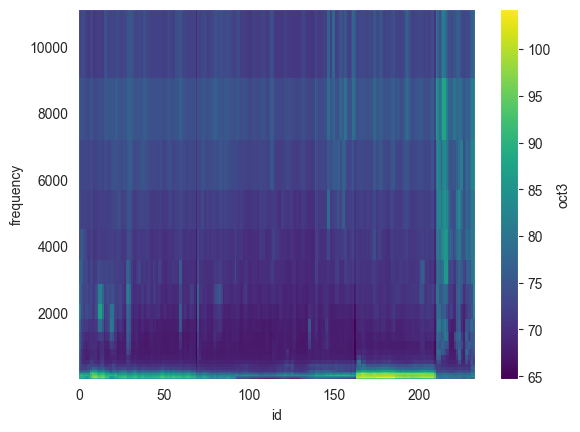

In [8]:
new_ds['oct3'].plot(x='id', y='frequency')

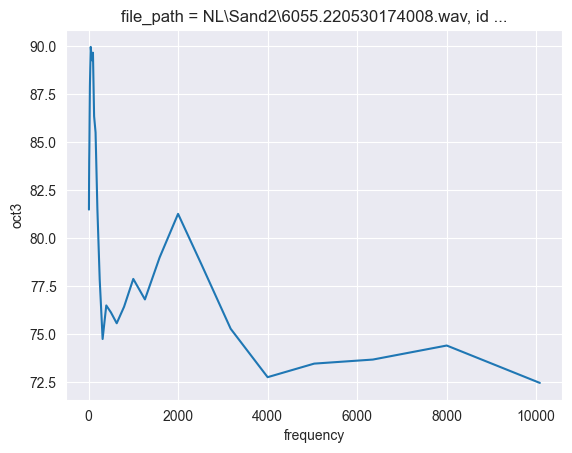

In [9]:
new_ds.sel(id=0)['oct3'].plot()